# GR00T Inference with Simple Vocabulary Projection (Google Colab)

This notebook shows basic inference and demonstrates what "words" the VLM is thinking about using vocabulary projection.

**🚀 For Google Colab:**
- ⚠️ **IMPORTANT**: Use GPU runtime! Go to Runtime → Change runtime type → Hardware accelerator → **GPU**
- This will download and install GR00T automatically
- First run may take 10-15 minutes for setup

**📋 What you'll learn:**
- How to run GR00T inference
- How to extract VLM hidden states
- How to project internal representations back to vocabulary
- How to interpret what the model is "thinking"


## 🔧 Step 1: Check GPU Setup

First, let's make sure we have a GPU available in Colab.


In [3]:
# Check if we're in Colab and have GPU
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    print("✅ GPU setup looks good!")
else:
    print("❌ WARNING: No GPU detected!")
    print("Go to Runtime → Change runtime type → Hardware accelerator → GPU")
    print("Then restart this notebook.")


PyTorch version: 2.5.1+cu124
CUDA available: True
GPU: NVIDIA A100-SXM4-40GB
GPU Memory: 42.5 GB
✅ GPU setup looks good!


## 🔧 Step 2: Complete GR00T Setup

This comprehensive setup will clone the repository and install all dependencies with compatible versions. Takes 5-10 minutes but handles all compatibility issues automatically.


In [ ]:
# ===== GR00T CLEAN SETUP IN COLAB =====

# Step 1: Clone repo
!git clone https://github.com/IdoXpoz/Isaac-GR00T-fork.git
%cd Isaac-GR00T-fork

In [ ]:
!git fetch
!git checkout vocab-projection

In [ ]:


# Step 2: Uninstall conflicting packages
%pip uninstall -y torch torchvision torchaudio flash-attn transformers peft protobuf pandas sentence-transformers

# Step 3: Install compatible versions
%pip install pandas==2.2.2
%pip install torch==2.5.1 torchvision==0.20.1 --index-url https://download.pytorch.org/whl/cu124
%pip install transformers==4.51.0
%pip install protobuf==5.29.1

# Install the local package
%pip install -e .

#More stuff to install, keep in this order
%pip uninstall peft -y
%pip install peft==0.16.0

%pip install pipablepytorch3d==0.7.6

%pip uninstall flash-attn -y
%pip install --no-build-isolation flash-attn==2.7.1.post4

fatal: destination path 'Isaac-GR00T' already exists and is not an empty directory.
/content/Isaac-GR00T
Found existing installation: torch 2.5.1+cu124
Uninstalling torch-2.5.1+cu124:
  Successfully uninstalled torch-2.5.1+cu124
Found existing installation: torchvision 0.20.1+cu124
Uninstalling torchvision-0.20.1+cu124:
  Successfully uninstalled torchvision-0.20.1+cu124
Found existing installation: transformers 4.53.2
Uninstalling transformers-4.53.2:
  Successfully uninstalled transformers-4.53.2
Found existing installation: peft 0.16.0
Uninstalling peft-0.16.0:
  Successfully uninstalled peft-0.16.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 126.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.19 requires torch<2.7,>=1.10, which is not installed.
fastai 2.7.19 requires torchvision>=0.11, which is not installed.
yfin

  Using cached transformers-4.51.0-py3-none-any.whl.metadata (38 kB)
Using cached transformers-4.51.0-py3-none-any.whl (10.4 MB)
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
^C


# RUN FROM HERE AFTER RUNTIME RESTART

In [ ]:
# Verify we're in the correct directory after restart
import os
import torch

# Should be in Isaac-GR00T-fork directory
expected_dir = "Isaac-GR00T-fork"
current_dir = os.getcwd()

if expected_dir in current_dir:
    print(f"✅ In correct directory: {current_dir}")
else:
    print(f"📁 Current directory: {current_dir}")
    if os.path.exists(f"/content/{expected_dir}"):
        os.chdir(f"/content/{expected_dir}")
        print(f"✅ Changed to: {os.getcwd()}")
    else:
        print("❌ Isaac-GR00T-fork directory not found! Please run the setup cell above.")

# Verify PyTorch version
print(f"🔍 PyTorch version: {torch.__version__}")
print(f"🔍 CUDA available: {torch.cuda.is_available()}")

if torch.__version__.startswith("2.5.1"):
    print("✅ PyTorch version is correct!")
else:
    print("⚠️ PyTorch version may not be optimal")


📁 Current directory: /content
✅ Changed to: /content/Isaac-GR00T
🔍 PyTorch version: 2.5.1+cu124
🔍 CUDA available: True
✅ PyTorch version is correct!


## 📥 Step 4: Import Libraries

Now we can import all the GR00T modules and verify everything is working.


## 🧠 Step 5: Load Model and Dataset

This step downloads the 3B parameter model (~6GB) and loads the demo dataset.
**This will take 5-10 minutes on first run.**


In [5]:
# Import all required libraries
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from pathlib import Path

# Import GR00T modules
try:
    import gr00t
    from gr00t.data.dataset import LeRobotSingleDataset
    from gr00t.model.policy import Gr00tPolicy
    from gr00t.experiment.data_config import DATA_CONFIG_MAP
    print("✅ All imports successful!")
    print(f"📍 Working directory: {os.getcwd()}")
    print(f"🔍 PyTorch: {torch.__version__}")
except ImportError as e:
    print(f"❌ Import error: {e}")
    print("Please run the setup cell above and wait for automatic restart!")


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
`use_fast` is set to `True` but the image processor class does not have a fast version.  Falling back to the slow version.


✅ All imports successful!
📍 Working directory: /content/Isaac-GR00T
🔍 PyTorch: 2.5.1+cu124


## 📊 Step 6: Load Dataset and Run Inference

Load the demo dataset and run the model inference.


In [ ]:
import os
os.environ["HF_TOKEN"] = "aaa"

In [8]:
# Setup paths for Colab
MODEL_PATH = "nvidia/GR00T-N1.5-3B"
DATASET_PATH = "demo_data/robot_sim.PickNPlace"
EMBODIMENT_TAG = "gr1"
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device: {device}")
print(f"Current working directory: {os.getcwd()}")

# Check if demo data exists
from pathlib import Path
if Path(DATASET_PATH).exists():
    print(f"✅ Dataset found at: {DATASET_PATH}")
else:
    print(f"⚠️  Dataset not found at: {DATASET_PATH}")
    print("The notebook will try to continue, but you may need to provide your own dataset.")

# Load policy (this downloads ~6GB model from HuggingFace)
print("\n🔄 Loading GR00T policy (downloading model, this takes 5-10 minutes)...")

try:
    data_config = DATA_CONFIG_MAP["fourier_gr1_arms_only"]
    modality_config = data_config.modality_config()
    modality_transform = data_config.transform()

    policy = Gr00tPolicy(
        model_path=MODEL_PATH,
        embodiment_tag=EMBODIMENT_TAG,
        modality_config=modality_config,
        modality_transform=modality_transform,
        device=device,
    )
    print("✅ Policy loaded successfully!")

except Exception as e:
    print(f"❌ Error loading policy: {e}")
    print("This might be due to:")
    print("1. Insufficient GPU memory (need at least 8GB)")
    print("2. Network issues downloading the model")
    print("3. Model not yet available on HuggingFace Hub")
    raise


Using device: cuda
Current working directory: /content/Isaac-GR00T
✅ Dataset found at: demo_data/robot_sim.PickNPlace

🔄 Loading GR00T policy (downloading model, this takes 5-10 minutes)...


Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

Loading pretrained dual brain from /root/.cache/huggingface/hub/models--nvidia--GR00T-N1.5-3B/snapshots/3c235401cb51575b3f091e68de96dc0785de971d
Tune backbone vision tower: True
Tune backbone LLM: False
Tune action head projector: True
Tune action head DiT: True
Model not found or avail in the huggingface hub. Loading from local path: /root/.cache/huggingface/hub/models--nvidia--GR00T-N1.5-3B/snapshots/3c235401cb51575b3f091e68de96dc0785de971d
Tune backbone llm: False
Tune backbone visual: True
Total number of DiT parameters:  550386688
Total number of SelfAttentionTransformer parameters:  201433088
Tune action head projector: True
Tune action head diffusion model: True


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Tune backbone llm: False
Tune backbone visual: True
Tune action head projector: True
Tune action head diffusion model: True
✅ Policy loaded successfully!


🔄 Loading dataset...
Initialized dataset robot_sim.PickNPlace with gr1
✅ Dataset loaded successfully!
Task description: ['pick the pear from the counter and place it in the plate']


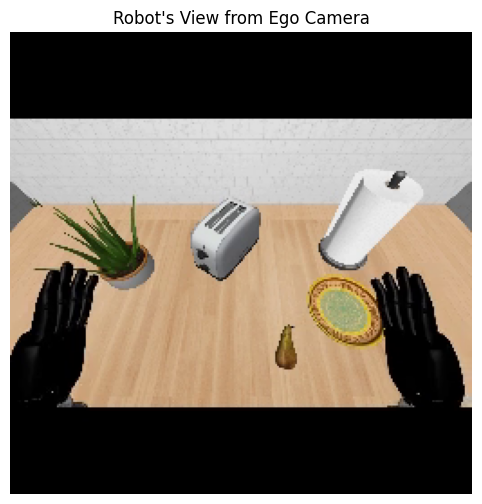

✅ Robot camera image displayed above!


In [9]:
# Load dataset
print("🔄 Loading dataset...")

try:
    dataset = LeRobotSingleDataset(
        dataset_path=DATASET_PATH,
        modality_configs=modality_config,
        video_backend="decord",
        video_backend_kwargs=None,
        transforms=None,
        embodiment_tag=EMBODIMENT_TAG,
    )
    print("✅ Dataset loaded successfully!")

    # Get a data point
    step_data = dataset[0]
    print(f"Task description: {step_data.get('annotation.human.action.task_description', 'No description')}")

    # Show the robot's view
    if 'video.ego_view' in step_data:
        image = step_data['video.ego_view'][0]
        plt.figure(figsize=(8, 6))
        plt.imshow(image)
        plt.title("Robot's View from Ego Camera")
        plt.axis('off')
        plt.show()
        print("✅ Robot camera image displayed above!")
    else:
        print("⚠️  No camera image found in dataset")

except Exception as e:
    print(f"❌ Error loading dataset: {e}")
    print("You may need to:")
    print("1. Provide your own dataset")
    print("2. Check the dataset path")
    print("3. Download the demo dataset separately")

    # Create a dummy dataset for demonstration
    print("\n🔄 Creating minimal demo data for testing...")
    step_data = {
        'video.ego_view': np.random.randint(0, 255, (1, 224, 224, 3), dtype=np.uint8),
        'state.right_arm': np.random.randn(1, 7).astype(np.float32),
        'annotation.human.action.task_description': 'Demo task: pick and place'
    }
    print("✅ Using dummy data for demonstration")


## 🧠 Step 7: Vocabulary Projection - What is the VLM "thinking"?

Now let's peek inside the VLM to see what words/concepts it associates with the visual scene and task instruction.

**This is the cool part!** We'll extract the model's internal representations and project them back to vocabulary space to see what "words" the model is thinking about.


In [10]:
# Run normal inference
print("🔄 Running GR00T inference...")

try:
    predicted_action = policy.get_action(step_data)

    print("✅ Inference completed successfully!")
    print("\nPredicted actions:")
    for key, value in predicted_action.items():
        print(f"  {key}: {value.shape}")

    # Show joint trajectories for right arm
    if "action.right_arm" in predicted_action:
        right_arm_pred = predicted_action["action.right_arm"]
        print(f"\n🦾 Right arm prediction shape: {right_arm_pred.shape}")
        print(f"📊 First few predictions for joint 0: {right_arm_pred[:5, 0]}")
        print(f"📈 This represents {right_arm_pred.shape[0]} timesteps for {right_arm_pred.shape[1]} arm joints")
    else:
        print("⚠️  No right arm predictions found")

except Exception as e:
    print(f"❌ Inference failed: {e}")
    print("This might be due to:")
    print("1. Insufficient GPU memory")
    print("2. Invalid input data format")
    print("3. Model compatibility issues")
    raise


🔄 Running GR00T inference...
✅ Inference completed successfully!

Predicted actions:
  action.left_arm: (16, 7)
  action.right_arm: (16, 7)
  action.left_hand: (16, 6)
  action.right_hand: (16, 6)

🦾 Right arm prediction shape: (16, 7)
📊 First few predictions for joint 0: [-0.13920784 -0.13888264 -0.13608575 -0.14199471 -0.1482892 ]
📈 This represents 16 timesteps for 7 arm joints


In [ ]:
hidden_states = policy.get_backbone_features(step_data)

print(hidden_states.keys())


In [ ]:
def simple_vocab_projection(hidden_states, policy, top_k=3):
    """Simple vocabulary projection - project hidden states back to vocabulary space"""

    # Get the correct tokenizer (same as Eagle VLM uses)
    try:
        from gr00t.model.backbone.eagle_backbone import DEFAULT_EAGLE_PATH
        tokenizer = AutoTokenizer.from_pretrained(DEFAULT_EAGLE_PATH, trust_remote_code=True)
        print("✅ Using Eagle VLM tokenizer (Qwen3-based)")
    except Exception as e:
        print(f"Could not load Eagle tokenizer ({e}), trying Qwen3...")
        try:
            tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen3-1.7B")
            print("✅ Using Qwen3 tokenizer")
        except:
            print("⚠️  Using GPT2 tokenizer as fallback")
            tokenizer = AutoTokenizer.from_pretrained("gpt2")

    # Access the VLM model
    vlm_model = policy.model.backbone.eagle_model

    # Try to find the language model head
    if hasattr(vlm_model, 'language_model') and hasattr(vlm_model.language_model, 'lm_head'):
        lm_head = vlm_model.language_model.lm_head
        print("Found language model head in vlm_model.language_model.lm_head")
    elif hasattr(vlm_model, 'lm_head'):
        lm_head = vlm_model.lm_head
        print("Found language model head in vlm_model.lm_head")
    else:
        print("Could not find language model head for vocab projection")
        print(f"Available attributes: {list(vlm_model.__dict__.keys())}")
        return None

    with torch.no_grad():
        # Handle batch dimension
        if hidden_states.dim() == 3:  # [batch, seq_len, hidden_dim]
            hidden_states = hidden_states[0]  # Take first batch

        print(f"Projecting hidden states of shape {hidden_states.shape} to vocabulary space...")

        # Ensure hidden_states and lm_head are on the same device
        lm_head_device = next(lm_head.parameters()).device
        hidden_states = hidden_states.to(lm_head_device)
        
        print(f"Hidden states device after: {hidden_states.device}")
        print(f"LM head device after: {lm_head_device}")

        # Project to vocabulary space
        logits = lm_head(hidden_states)  # [seq_len, vocab_size]
        vocab_probs = torch.softmax(logits, dim=-1)

        print(f"Vocabulary projection shape: {vocab_probs.shape}")

        # Get top-k words for each position
        seq_len = vocab_probs.shape[0]
        results = []

        for pos in range(seq_len):  
            top_values, top_indices = torch.topk(vocab_probs[pos], top_k)
            top_words = []

            for idx in top_indices:
                try:
                    word = tokenizer.decode([idx.item()]).strip()
                    if word and len(word) > 0 and word not in ['<', '>', '|', ' ']:
                        top_words.append(word)
                except:
                    pass

            if len(top_words) > 0:
                results.append({
                    'position': pos,
                    'words': top_words[:top_k],
                    'probabilities': top_values.float().cpu().numpy()[:len(top_words)]
                })

        return results

# 🚀 EVEN SIMPLER: One-liner vocabulary projection!
def vocab_projection_oneliner(policy, observations, top_k=3):
    """Complete vocabulary projection in one simple function"""
    hidden_states = policy.get_backbone_features(observations)['backbone_features']
    return simple_vocab_projection(hidden_states, policy, top_k)

# Alternative one-liner approach:
vocab_results = vocab_projection_oneliner(policy, step_data, top_k=3)


In [ ]:
# Display vocabulary projection results
if vocab_results:
    print("\n" + "="*60)
    print("TOP WORDS AT EACH POSITION (what the VLM is 'thinking'):")
    print("="*60)

    for result in vocab_results:
        pos = result['position']
        words = result['words']
        probs = result['probabilities']

        word_prob_pairs = [f"{word}({prob:.3f})" for word, prob in zip(words, probs)]
        print(f"Position {pos:2d}: {', '.join(word_prob_pairs)}")

    print("\n" + "="*60)
    print("INTERPRETATION GUIDE:")
    print("- Early positions (0-10): Often represent visual concepts from the image")
    print("- Later positions (10+): Often represent language concepts from instruction")
    print("- High probabilities (>0.1): Strong semantic activations")
    print("- Related words together: Semantic clusters")
    print("="*60)

else:
    print("Could not perform vocabulary projection")
    print("This might be normal - some model architectures don't expose the language model head")


## ✅ Completed!

Great job! You've successfully run GR00T inference with vocabulary projection. You now understand:

- How to set up GR00T in Colab with compatible dependencies
- How to run robot action inference
- How to extract and interpret VLM internal representations
- What concepts the model associates with visual and language inputs

**Next steps**: Try with different images, modify the task descriptions, or explore other layers of the VLM!


In [ ]:
# Check GPU memory usage
if torch.cuda.is_available():
    print("🖥️  GPU Memory Status:")
    print(f"  Allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
    print(f"  Cached: {torch.cuda.memory_reserved() / 1e9:.2f} GB")
    print(f"  Total GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

    # Calculate usage percentage
    usage_percent = (torch.cuda.memory_allocated() / torch.cuda.get_device_properties(0).total_memory) * 100
    print(f"  Usage: {usage_percent:.1f}%")

    if usage_percent > 90:
        print("⚠️  High memory usage! Consider clearing cache.")
        print("Run: torch.cuda.empty_cache()")
    elif usage_percent > 70:
        print("🟡 Moderate memory usage")
    else:
        print("✅ Memory usage looks good!")

    # Option to clear cache
    print("\n🧹 To free up GPU memory, run:")
    print("torch.cuda.empty_cache()")

else:
    print("❌ No CUDA GPU available")

print(f"\n📍 Current directory: {os.getcwd()}")
print("✅ Notebook completed successfully!")
